In [1]:
import pickle
import radvel
import rebound as rb
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from scipy import optimize, stats
import corner
from radvel.plot import mcmc_plots
import reboundx
import emcee
from multiprocessing import Pool
import h5py
import time
from celmech.nbody_simulation_utilities import align_simulation
from tqdm import tqdm
from rebound.interruptible_pool import InterruptiblePool

/home/ianchow/.local/lib/python3.10/site-packages/radvel/gp.py:32: ImportWarning: celerite not installed. GP kernals using celerite will not work. Try installing celerite using 'pip install celerite'
  warnings.warn("celerite not installed. GP kernals using celerite will not work. \


**All the fitting/analysis in this notebook was done using a libration penalty**

In [2]:
pl.rc('font', size=18)

In [3]:
hd_data = pd.read_csv('hd45364_rvs.csv', sep = ';')
# giant outlier at position 116 in the data (found manually earlier) which we remove
hd_data.drop(116, inplace=True)  # drop the row and keep the df in place
# subtract 2.4e6 from all the rows in the data
hd_data.BJD -= 2.4e6

In [4]:
#Very original parameters used in Hadden and Payne
nbody_params =[ 2.27798546e+02,  7.25405874e+00,  5.39392010e+04,  1.71866112e-01, 
               1.17923823e-01,  3.43881599e+02,  1.87692753e+01,  5.40138425e+04, 
               1.68408461e-01,  5.05903191e-02, -3.28526403e-03, 1, 1.84]

#Least squares fit: 
fit_params = [ 2.28512793e+02, 7.27736501e+00, 5.39371914e+04, -4.66868256e-02, 
               -1.78080009e-01, 3.43378038e+02, 1.78603341e+01, 5.40186750e+04, 
               9.72945632e-02,  1.32194117e-01, -5.29072002e-01, 1, 2.428]#-7.68527759e-03] 

In [5]:
## CONSTANTS:

STAR_MASS = 920  # 920 jupiter masses
G = 2.825e-7  # converting G to jupiter masses, au, and days
AUDAY_MS = 1.731e6  # conversion factor for au/day to m/s


# use median of time data as the time base:
obs_time_base = np.median(hd_data.BJD)

# print(f'nbody_params:{nbody_params}\n fit_params:{fit_params}')

def mass_to_semiamp(planet_mass, star_mass, period, eccentricity, inclination):
    """
    planet mass (jupiter masses) to semi amplitude (in au/day)
    """
    return ((2 * np.pi * G/period) ** (1/3) * (planet_mass * np.sin(inclination) / star_mass ** (2/3)) * (1/np.sqrt(1 - eccentricity ** 2)))

def semiamp_to_mass(semiamp, star_mass, period, eccentricity, inclination):
    """
    semi amplitude (in au/day) to planet mass (jupiter masses)
    """
    return (((2 * np.pi * G/period) ** (-1/3)) * (semiamp / np.sin(inclination)) * np.sqrt(1 - eccentricity ** 2) * (star_mass ** (2/3)))


def get_sim_from_params(params, integrator, time_base, star_mass = STAR_MASS, auday_ms = AUDAY_MS):
    """
    takes in params array, returns a rebound Simulation object with those parameters
    
    param params: numpy array of params:
    
    for i in range(0, num_planets):
    
    params[i + 0] is period
    params[i + 1] is semiamp
    params[i + 2] is tc (time of conjunction)
    params[i + 3] is sqrt(e) * cos(omega)
    params[i + 4] is sqrt(e) * sin(omega)
    
    params[5 * num_planets] is rv offset
    params[5 * num_planets + 1] is sin(i)
    params[5 * num_planets + 2] is jitter (not used in this specific function but used in some other functions that call this one)
    
    param integrator: integrator to use, one of 'whfast' or 'ias15'
    param time_base: base time (to begin integration from) in the simulation
    """
    
    num_planets = int((len(params) - 1) / 5) # -2 because there are rv_offset and jit parameters:
    
    sim = rb.Simulation()
    sim.integrator = integrator
    sim.t = time_base  # keplerian and n-body models initialized at the same time offset
    # print(sim.t)
    if integrator == 'whfast':  # if using whfast integrator, set timestep
        sim.dt = 1/50 * min(params[0::5][:-1])  # timestep is 1/20th of the shortest orbital period of any planet
        # print(sim.dt)
    sim.units = ('AU', 'Mjupiter', 'day')
    sim.add(m = star_mass)  # star mass as a constant
    
    inclination = np.arcsin(params[-2])  # sin(i) is second from the back of the array
        
    for i in range (0, num_planets):
        # print(i)
        # planet parameters
        period = params[5*i]  # in days
        semiamp = params[5*i + 1] / auday_ms # divide by auday_ms because semiamp given in m/s
        eccentricity = params[5*i + 3] ** 2 + params[5*i + 4] ** 2  # eccentricity from secos, sesin
        omega = np.arctan2(params[5*i + 4], params[5*i + 3])  # omega from arctan of sesin, secos  (in that order!)
        # get tp by converting from tc
        tp = radvel.orbit.timetrans_to_timeperi(tc = params[5*i + 2], per = period, ecc = eccentricity, omega = omega)
        
        # mass
        mass = semiamp_to_mass(semiamp = semiamp, star_mass = star_mass, period = period, eccentricity = eccentricity, inclination = inclination)
        
        # adding to simulation
        sim.add(m = mass, P = period, e = eccentricity, T = tp, omega = omega, inc = inclination)
        
    sim.move_to_com()  # move to center of mass
    
    return sim

def get_simple_sim(masses, integrator = 'ias15', period_ratio = 3/2, epsilon=0.01):
    """
    gets simple sim (for eccentricity track stuff)
    param masses: array of planet masses
    param integrator: integrator
    param epsilon: amount by which the resonant period ratio should be offset from the equilibrium in the simulation
    """
    sim = rb.Simulation()
    sim.integrator = integrator
    # central star
    sim.add(m = 1)
    
    sim.add(m = masses[0], P = 1)
    sim.add(m = masses[1], P = period_ratio * (1 + epsilon))

    sim.move_to_com()
    if integrator == 'whfast':
        sim.dt = 1/50 * 1  # dy default use 1/50th of the inner planet's orbital period for the timestep if using whfast
    return sim


def get_rvs(params, times, integrator, time_base, auday_ms = AUDAY_MS):
    
    """
    Gets RVs from a Numpy array of planet params
    
    param params:     for i in range(0, num_planets):
    
    params[i + 0] is period
    params[i + 1] is semiamp
    params[i + 2] is tc (time of conjunction)
    params[i + 3] is sqrt(e) * cos(omega)
    params[i + 4] is sqrt(e) * sin(omega)
    
    params[5 * num_planets] is rv offset
    params[5 * num_planets + 1] is sin(i) (also params[-2])
    params[5 * num_planets + 2] is jitter (also params[-1])
    
    param inclination: inclination of system in the observation plane (pi/2 is in the plane of the sky, 0 is edge-on)
    param times: array of times to integrate over
    param integrator: integrator to use, one of 'whfast' or 'ias15'
    
    """
    
    sim = get_sim_from_params(params, integrator, time_base = time_base)
    
    sim_backwards = sim.copy()
    sim_backwards.dt *= -1  # set timestep to be negative if integrating backwards
    
    forward_times = np.array(list(filter(lambda x: x - time_base >= 0, times)))
    backward_times = np.array(list(filter(lambda x: x - time_base < 0, times)))
    
    # initialize rvs
    rv_forward = np.zeros(len(forward_times))
    rv_backward = np.zeros(len(backward_times))
    
    num_planets = int((len(params) - 1) / 5)  # find number of planets in params passed
    
    # get the rvs (z velocity, assuming 90 deg inclination) from the rebound simulation to compare with the actual simulation
    for i, t in enumerate(forward_times):
        sim.integrate(t, exact_finish_time = 1)
        # integrate to the specified time, exact_finish_time = 1 for ias15, 
        # sim.status()
        star = sim.particles[0]
        rv_forward[i] = (-star.vz * auday_ms) + params[5 * num_planets]  # use x-velocity of the star as the radial velocity, convert to m/s
    
    for i, t in enumerate(backward_times):
        sim_backwards.integrate(t, exact_finish_time = 1)
        star = sim_backwards.particles[0]
        rv_backward[i] = (-star.vz * auday_ms) + params[5 * num_planets]
    
    return np.concatenate((rv_backward, rv_forward))

In [62]:
def mass_to_semiamp(planet_mass, star_mass, period, eccentricity, inclination):
    """
    planet mass (jupiter masses) to semi amplitude (in au/day)
    """
    return ((2 * np.pi * G/period) ** (1/3) * (planet_mass * np.sin(inclination) / star_mass ** (2/3)) * (1/np.sqrt(1 - eccentricity ** 2)))

def semiamp_to_mass(semiamp, star_mass, period, eccentricity, inclination):
    """
    semi amplitude (in au/day) to planet mass (jupiter masses)
    """
    return (((2 * np.pi * G/period) ** (-1/3)) * (semiamp / np.sin(inclination)) * np.sqrt(1 - eccentricity ** 2) * (star_mass ** (2/3)))


def get_sim_from_params(params, integrator, time_base, star_mass = STAR_MASS, auday_ms = AUDAY_MS):
    """
    takes in params array, returns a rebound Simulation object with those parameters
    
    param params: numpy array of params:
    
    for i in range(0, num_planets):
    
    params[i + 0] is period
    params[i + 1] is semiamp
    params[i + 2] is tc (time of conjunction)
    params[i + 3] is sqrt(e) * cos(omega)
    params[i + 4] is sqrt(e) * sin(omega)
    
    params[5 * num_planets] is rv offset
    params[5 * num_planets + 1] is sin(i)
    params[5 * num_planets + 2] is jitter (not used in this specific function but used in some other functions that call this one)
    
    param integrator: integrator to use, one of 'whfast' or 'ias15'
    param time_base: base time (to begin integration from) in the simulation
    """
    
    num_planets = int((len(params) - 1) / 5) # -2 because there are rv_offset and jit parameters:
    
    sim = rb.Simulation()
    sim.integrator = integrator
    sim.t = time_base  # keplerian and n-body models initialized at the same time offset
    # print(sim.t)
    if integrator == 'whfast':  # if using whfast integrator, set timestep
        sim.dt = 1/50 * min(params[0::5][:-1])  # timestep is 1/20th of the shortest orbital period of any planet
        # print(sim.dt)
    sim.units = ('AU', 'Mjupiter', 'day')
    sim.add(m = star_mass)  # star mass as a constant
    
    inclination = np.arcsin(params[-2])  # sin(i) is second from the back of the array
        
    for i in range (0, num_planets):
        # print(i)
        # planet parameters
        period = params[5*i]  # in days
        semiamp = params[5*i + 1] / auday_ms # divide by auday_ms because semiamp given in m/s
        eccentricity = params[5*i + 3] ** 2 + params[5*i + 4] ** 2  # eccentricity from secos, sesin
        omega = np.arctan2(params[5*i + 4], params[5*i + 3])  # omega from arctan of sesin, secos  (in that order!)
        # get tp by converting from tc
        tp = radvel.orbit.timetrans_to_timeperi(tc = params[5*i + 2], per = period, ecc = eccentricity, omega = omega)
        
        # mass
        mass = semiamp_to_mass(semiamp = semiamp, star_mass = star_mass, period = period, eccentricity = eccentricity, inclination = inclination)

        # print(mass, period, eccentricity, tp, omega, inclination)
        # adding to simulation
        sim.add(m = mass, P = period, e = eccentricity, T = tp, omega = omega, inc = inclination)
        
    sim.move_to_com()  # move to center of mass
    
    return sim

def get_simple_sim(masses, integrator = 'ias15', period_ratio = 3/2, epsilon=0.01):
    """
    gets simple sim (for eccentricity track stuff)
    param masses: array of planet masses
    param integrator: integrator
    param epsilon: amount by which the resonant period ratio should be offset from the equilibrium in the simulation
    """
    sim = rb.Simulation()
    sim.integrator = integrator
    # central star
    sim.add(m = 1)
    
    sim.add(m = masses[0], P = 1)
    sim.add(m = masses[1], P = period_ratio * (1 + epsilon))

    sim.move_to_com()
    if integrator == 'whfast':
        sim.dt = 1/50 * 1  # dy default use 1/50th of the inner planet's orbital period for the timestep if using whfast
    return sim


def get_rvs(params, times, integrator, time_base, auday_ms = AUDAY_MS):
    
    """
    Gets RVs from a Numpy array of planet params
    
    param params:     for i in range(0, num_planets):
    
    params[i + 0] is period
    params[i + 1] is semiamp
    params[i + 2] is tc (time of conjunction)
    params[i + 3] is sqrt(e) * cos(omega)
    params[i + 4] is sqrt(e) * sin(omega)
    
    params[5 * num_planets] is rv offset
    params[5 * num_planets + 1] is sin(i) (also params[-2])
    params[5 * num_planets + 2] is jitter (also params[-1])
    
    param inclination: inclination of system in the observation plane (pi/2 is in the plane of the sky, 0 is edge-on)
    param times: array of times to integrate over
    param integrator: integrator to use, one of 'whfast' or 'ias15'
    
    """
    
    sim = get_sim_from_params(params, integrator, time_base = time_base)
    
    sim_backwards = sim.copy()
    sim_backwards.dt *= -1  # set timestep to be negative if integrating backwards
    
    forward_times = np.array(list(filter(lambda x: x - time_base >= 0, times)))
    backward_times = np.array(list(filter(lambda x: x - time_base < 0, times)))
    
    # initialize rvs
    rv_forward = np.zeros(len(forward_times))
    rv_backward = np.zeros(len(backward_times))
    
    num_planets = int((len(params) - 1) / 5)  # find number of planets in params passed
    
    # get the rvs (z velocity, assuming 90 deg inclination) from the rebound simulation to compare with the actual simulation
    for i, t in enumerate(forward_times):
        sim.integrate(t, exact_finish_time = 1)
        # integrate to the specified time, exact_finish_time = 1 for ias15, 
        # sim.status()
        star = sim.particles[0]
        rv_forward[i] = (-star.vz * auday_ms) + params[5 * num_planets]  # use x-velocity of the star as the radial velocity, convert to m/s
    
    for i, t in enumerate(backward_times):
        sim_backwards.integrate(t, exact_finish_time = 1)
        star = sim_backwards.particles[0]
        rv_backward[i] = (-star.vz * auday_ms) + params[5 * num_planets]
    
    return np.concatenate((rv_backward, rv_forward))

These functions are taken from `hd_mcmc_jitter_everything_with_libration_penalty.py`, edited from `radvel_hd45364-sin_i_jitter.ipynb`, to account for the libration penalty in addition to sin(i) and jitter.

In [33]:
def get_nbody_resids_jitter_libration(params, Alib=0.3, nperiods=500, nsamples=1000, integrator='ias15', data=hd_data, time_base=np.median(hd_data.BJD)):
    """
    Gets the normalized residuals for the n-body fit with REBOUND, penalizing for the RMS of the libration angle a 
    and for jitter, holding each of them constant (this is the function we want to optimize)
    
    params is in the form of params for the 10-param model (n-body rebound):

    param params: numpy array of params:
    
    for i in range(0, num_planets):
    
    params[i + 0] is period
    params[i + 1] is semiamp
    params[i + 2] is tc (time of conjunction)
    params[i + 3] is sqrt(e) * cos(omega)
    params[i + 4] is sqrt(e) * sin(omega)
    
    params[5 * num_planets] is rv offset
    params[5 * num_planets + 1] is sin(i)
    params[5 * num_planets + 2] is jitter

    defaults:
    param Alib: magnitude of the libration penalty (RMS) to apply, default is 0.3
    param nperiods: number of periods of the inner planet to integrate over when computing the RMS of the libration angle A 
    (finding libration angles from omega using a rebound simulation), default is 500
    param nsamples: number of samples (timesteps) from 0 to nperiod inner planet periods to integrate over, default is 1000
    """
    
    # get times
    times = data.BJD
    # get jitter
    jitter = params[-1]  # jitter is at the back of the parameter array
    
    # compute normalized residuals
    obs_y = data.RV_mlc_nzp  # observed RVs
    # get rvs holding jitter constant
    synth_y = get_rvs(params, times, integrator, time_base)  # RVs from the rebound simulation
    obs_yerr = data.e_RV_mlc_nzp  # y errors
    
    # first compute normalized residuals including jitter term
    jitter_normalized_resids = (obs_y - synth_y)/np.sqrt(obs_yerr ** 2 + jitter ** 2)  # compute normalized residuals using rebound
    
    # now compute the A_lib "residuals" to penalize the fit with:
    
    # define p1
    p1 = params[0]

    # # compute the rms of the libration angle a (find libration angles from omega using a rebound simulation)
    # nperiods = 500  # number of peirods
    # # measure the libration amplitude over 1000 periods of the inner planet (longer time array than for the residuals)
    # nsamples = 1000
    
    angle_times = np.linspace(0, 0 + p1 * nperiods, nsamples)  # angle times, use length of observed rvs
    angle_time_base = 0#np.median(angle_times)  # reset angle time base to something else to find the libration amplitude 
    # initialize sim
    angle_sim = get_sim_from_params(params, integrator='whfast', time_base=0)
    inner = angle_sim.particles[1]
    outer = angle_sim.particles[2]
    # define empty arrays
    angle1, angle2 = np.zeros((2, nsamples))  # init empty arrays
    # now compute the libration angle arrays
    # test2 = np.zeros(len(angle_times))
    for i, t in enumerate(angle_times):
        angle_sim.integrate(t, exact_finish_time = 0)
        resonant_angle = 3 * outer.l - 2 * inner.l  # 3*lambda_2 - 2*lambda_1
        # test2[i] = resonant_angle
        angle1[i] = np.mod(resonant_angle - inner.pomega, 2 * np.pi)  # 3*lambda_2 - 2*lambda_1 - pomega_1, mod 2pi
        angle2[i] = np.mod(resonant_angle - outer.pomega, 2 * np.pi)  # 3*lambda_2 - 2*lambda_1 - pomega_2, mod 2pi

    # print(Alib, np.sqrt(len(angle1)))
    # now return the rms libration amplitude for inner and outer to penalize by
    # compute the normalized "residuals" A_lib_resids_1 (inner planet) and A_lib_resids_2 (outer planet)
    A_lib_normalized_resids_1 = np.array([(angle - 0)/(Alib * np.sqrt(len(angle1))) 
                     for angle in [angle - 2 * np.pi if angle > np.pi else angle for angle in angle1]])  # since inner planet oscillates around 0
    A_lib_normalized_resids_2 = np.array([(angle - np.pi)/(Alib * np.sqrt(len(angle2))) for angle in angle2])  # since outer planet oscillates around pi
    # print(res1, res1)
    # return normalized residuals plus the "residuals" used for the RMS libration amplitude penalty
    return np.concatenate((jitter_normalized_resids, A_lib_normalized_resids_1, A_lib_normalized_resids_2))  # concatenate all 3 arrays to pass to the least squares optimizer


def neg_log_likelihood(params, Alib=0.3, nperiods=500, nsamples=1000, data = hd_data):
    """
    Gets the negative log-likelihood (including a jitter term!) for the n-body fit with REBOUND to use with scipy.optimize.minimze,
    penalizing for the RMS of the libration angle a and for jitter, with each of them constant:
    
    params is in the form of params for the 10-param model (n-body rebound):

    param params: numpy array of params:
    
    for i in range(0, num_planets):
    
    params[i + 0] is period
    params[i + 1] is semiamp
    params[i + 2] is tc (time of conjunction)
    params[i + 3] is sqrt(e) * cos(omega)
    params[i + 4] is sqrt(e) * sin(omega)
    
    params[5 * num_planets] is rv offset
    params[5 * num_planets + 1] is sin(i)
    params[5 * num_planets + 2] is jitter

    defaults:
    param Alib: magnitude of the libration penalty (RMS) to apply, default is 0.3
    param nperiods: number of periods of the inner planet to integrate over when computing the RMS of the libration angle A 
    (finding libration angles from omega using a rebound simulation), default is 500
    param nsamples: number of samples (timesteps) from 0 to nperiod inner planet periods to integrate over, default is 1000
    
    """
    obs_y = data.RV_mlc_nzp  # observed RVs
    jitter = params[-1]  # jitter is at the back of the parameter array, and is handeld separately
    # inclination not handled sparately
    # inclination = np.arcsin(params[-2])  # inclination is np.arcsin of the second to last parameter
    
    synth_y = get_rvs(params, data.BJD, 'ias15', time_base = obs_time_base)  # RVs from the rebound simulation
    obs_yerr = data.e_RV_mlc_nzp  # y errors
    
    # so log likelihood is normally computed as:
    # L = -1/2 * np.sum((jitter_normalized_resids ** 2) + np.log(np.sqrt(2 * np.pi * (obs_yerr ** 2 + jitter ** 2))))
    # we modify the formula to add A_lib penalties in the form of additional "residuals" A_lib_normalized_resids_1 and 2. After concatenating all three sets of residuals ever, we now compute it as:
    # l_pen = -1/2 * (np.sum((jitter_normalized_resids ** 2) + np.log(np.sqrt(2 * np.pi * (obs_yerr ** 2 + jitter ** 2)))) + np.sum(A_lib_normalized_resids_1 ** 2) + np.sum(A_lib_normalized_resids_2 ** 2))
    
    # log_likelihood = -1/2 * np.sum(((obs_y - synth_y) ** 2)/(obs_yerr ** 2 + jitter ** 2) 
    #                                + np.log(np.sqrt(2 * np.pi * (obs_yerr ** 2 + jitter ** 2))))

    # first compute the normalized residuals taking into account jitter, as follows:
    jitter_normalized_resids = (obs_y - synth_y)/np.sqrt(obs_yerr ** 2 + jitter ** 2)  # compute normalized residuals using rebound
    
    # now compute the A_lib "residuals" to penalize the fit with:

    # define p1
    p1 = params[0]

    # # compute the rms of the libration angle a (find libration angles from omega using a rebound simulation)
    # nperiods = 500  # number of peirods
    # # measure the libration amplitude over 1000 periods of the inner planet (longer time array than for the residuals)
    # nsamples = 1000
    
    angle_times = np.linspace(0, 0 + p1 * nperiods, nsamples)  # angle times, use length of observed rvs
    angle_time_base = 0#np.median(angle_times)  # reset angle time base to something else to find the libration amplitude 
    # initialize sim
    angle_sim = get_sim_from_params(params, integrator='whfast', time_base=0)
    inner = angle_sim.particles[1]
    outer = angle_sim.particles[2]
    # define empty arrays
    angle1, angle2 = np.zeros((2, nsamples))  # init empty arrays
    # now compute the libration angle arrays
    # test2 = np.zeros(len(angle_times))
    for i, t in enumerate(angle_times):
        angle_sim.integrate(t, exact_finish_time = 0)
        resonant_angle = 3 * outer.l - 2 * inner.l  # 3*lambda_2 - 2*lambda_1
        # test2[i] = resonant_angle
        angle1[i] = np.mod(resonant_angle - inner.pomega, 2 * np.pi)  # 3*lambda_2 - 2*lambda_1 - pomega_1, mod 2pi
        angle2[i] = np.mod(resonant_angle - outer.pomega, 2 * np.pi)  # 3*lambda_2 - 2*lambda_1 - pomega_2, mod 2pi

    # print(Alib, np.sqrt(len(angle1)))
    # now return the rms libration amplitude for inner and outer to penalize by
    # compute the normalized "residuals" A_lib_resids_1 (inner planet) and A_lib_resids_2 (outer planet)
    A_lib_normalized_resids_1 = np.array([(angle - 0)/(Alib * np.sqrt(len(angle1))) 
                     for angle in [angle - 2 * np.pi if angle > np.pi else angle for angle in angle1]])  # since inner planet oscillates around 0
    A_lib_normalized_resids_2 = np.array([(angle - np.pi)/(Alib * np.sqrt(len(angle2))) for angle in angle2])  # since outer planet oscillates around pi

    # after computing jitter_normalized_resids and A_lib_resids_1 and 2, we finally have the modified log-likelihood as:
    
    log_likelihood_pen = -1/2 * (np.sum((jitter_normalized_resids ** 2) + np.log(np.sqrt(2 * np.pi * (obs_yerr ** 2 + jitter ** 2)))) + np.sum(A_lib_normalized_resids_1 ** 2) + np.sum(A_lib_normalized_resids_2 ** 2))

    # and return the modified log_likelihood:
    return -log_likelihood_pen  # negative since we are trying to minimize the negative log likelihood

def log_likelihood(params, Alib=0.3, nperiods=500, nsamples=1000, data = hd_data):
    """
    Gets the negative log-likelihood (including a jitter term!) for the n-body fit with REBOUND to use with scipy.optimize.minimze,
    penalizing for the RMS of the libration angle a and for jitter, with each of them constant:
    
    params is in the form of params for the 10-param model (n-body rebound):

    param params: numpy array of params:
    
    for i in range(0, num_planets):
    
    params[i + 0] is period
    params[i + 1] is semiamp
    params[i + 2] is tc (time of conjunction)
    params[i + 3] is sqrt(e) * cos(omega)
    params[i + 4] is sqrt(e) * sin(omega)
    
    params[5 * num_planets] is rv offset
    params[5 * num_planets + 1] is sin(i)
    params[5 * num_planets + 2] is jitter

    defaults:
    param Alib: magnitude of the libration penalty (RMS) to apply, default is 0.3
    param nperiods: number of periods of the inner planet to integrate over when computing the RMS of the libration angle A 
    (finding libration angles from omega using a rebound simulation), default is 500
    param nsamples: number of samples (timesteps) from 0 to nperiod inner planet periods to integrate over, default is 1000
    
    """
    obs_y = data.RV_mlc_nzp  # observed RVs
    jitter = params[-1]  # jitter is at the back of the parameter array, and is handeld separately
    # inclination not handled sparately
    # inclination = np.arcsin(params[-2])  # inclination is np.arcsin of the second to last parameter
    
    synth_y = get_rvs(params, data.BJD, 'ias15', time_base = obs_time_base)  # RVs from the rebound simulation
    obs_yerr = data.e_RV_mlc_nzp  # y errors
    
    # so log likelihood is normally computed as:
    # L = -1/2 * np.sum((jitter_normalized_resids ** 2) + np.log(np.sqrt(2 * np.pi * (obs_yerr ** 2 + jitter ** 2))))
    # we modify the formula to add A_lib penalties in the form of additional "residuals" A_lib_normalized_resids_1 and 2. After concatenating all three sets of residuals ever, we now compute it as:
    # l_pen = -1/2 * (np.sum((jitter_normalized_resids ** 2) + np.log(np.sqrt(2 * np.pi * (obs_yerr ** 2 + jitter ** 2)))) + np.sum(A_lib_normalized_resids_1 ** 2) + np.sum(A_lib_normalized_resids_2 ** 2))
    
    # log_likelihood = -1/2 * np.sum(((obs_y - synth_y) ** 2)/(obs_yerr ** 2 + jitter ** 2) 
    #                                + np.log(np.sqrt(2 * np.pi * (obs_yerr ** 2 + jitter ** 2))))

    # first compute the normalized residuals taking into account jitter, as follows:
    jitter_normalized_resids = (obs_y - synth_y)/np.sqrt(obs_yerr ** 2 + jitter ** 2)  # compute normalized residuals using rebound
    
    # now compute the A_lib "residuals" to penalize the fit with:

    # define p1
    p1 = params[0]

    # # compute the rms of the libration angle a (find libration angles from omega using a rebound simulation)
    # nperiods = 500  # number of peirods
    # # measure the libration amplitude over 1000 periods of the inner planet (longer time array than for the residuals)
    # nsamples = 1000
    
    angle_times = np.linspace(0, 0 + p1 * nperiods, nsamples)  # angle times, use length of observed rvs
    angle_time_base = 0#np.median(angle_times)  # reset angle time base to something else to find the libration amplitude 
    # initialize sim
    angle_sim = get_sim_from_params(params, integrator='whfast', time_base=0)
    inner = angle_sim.particles[1]
    outer = angle_sim.particles[2]
    # define empty arrays
    angle1, angle2 = np.zeros((2, nsamples))  # init empty arrays
    # now compute the libration angle arrays
    # test2 = np.zeros(len(angle_times))
    for i, t in enumerate(angle_times):
        angle_sim.integrate(t, exact_finish_time = 0)
        resonant_angle = 3 * outer.l - 2 * inner.l  # 3*lambda_2 - 2*lambda_1
        # test2[i] = resonant_angle
        angle1[i] = np.mod(resonant_angle - inner.pomega, 2 * np.pi)  # 3*lambda_2 - 2*lambda_1 - pomega_1, mod 2pi
        angle2[i] = np.mod(resonant_angle - outer.pomega, 2 * np.pi)  # 3*lambda_2 - 2*lambda_1 - pomega_2, mod 2pi
    
    # now return the rms libration amplitude for inner and outer to penalize by
    # compute the normalized "residuals" A_lib_resids_1 (inner planet) and A_lib_resids_2 (outer planet)
    A_lib_normalized_resids_1 = np.array([(angle - 0)/(Alib * np.sqrt(len(angle1))) 
                     for angle in [angle - 2 * np.pi if angle > np.pi else angle for angle in angle1]])  # since inner planet oscillates around 0
    A_lib_normalized_resids_2 = np.array([(angle - np.pi)/(Alib * np.sqrt(len(angle2))) for angle in angle2])  # since outer planet oscillates around pi

    # after computing jitter_normalized_resids and A_lib_resids_1 and 2, we finally have the modified log-likelihood as:
    
    log_likelihood_pen = -1/2 * (np.sum((jitter_normalized_resids ** 2) + np.log(np.sqrt(2 * np.pi * (obs_yerr ** 2 + jitter ** 2)))) + np.sum(A_lib_normalized_resids_1 ** 2) + np.sum(A_lib_normalized_resids_2 ** 2))

    # and return the modified log_likelihood:
    return log_likelihood_pen  # positive in this case unlike neg_log_likelihood above

In [24]:
# LOG PRIOR
def log_prior(params, e_max=0.8, sin_i_min=0.3):
    ps = params[0:-3:5]  # start at 0, the last 3 elements of params are not planet params (rv_offset, sin(i), jitter)
    ks = params[1:-3:5]  # semiamps
    tcs = params[2:-3:5]  # times of conjunction
    # compute e and omega from secos, sesin
    es = params[3:-3:5] ** 2 + params[4:-3:5] ** 2  # eccentricity from secos, sesin
    # omega = np.arctan2(params[3:-3:5], params[4:-3:5])  # omega from arctan of sesin, secos
    sin_i = params[-2]  # sin(i) is the second-to-last item of the array

    # uniform log prior, return 0 if param falls within uniform distribution, -infinity otherwise
    # print(ps, ks, tcs, es, omega)

    if all(p > 0 for p in ps) and all(k > 0 for k in ks) and all(tc > 0 for tc in tcs) and all(0 < e < e_max for e in es) and (sin_i_min < sin_i <= 1.):
        return 0.0  # log prior, so ln(1) = 0
    else:
        return -np.inf  # log prior, so ln(0) = -infinity

# LOG PROBABILITY
def log_probability(params):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params)

Compute the best-fit solution, taking into account the libration penalty:

In [8]:
# AGAIN, OPTIMIZE USING OPTIMIZE.MINIMIZE WITH THE LOG LIKELIHOOD INSTEAD OF JUST NORMAL LEAST-SQUARES

# bounds of (0, 1) for sin(i), everything else can vary however
bounds = ((None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (0, 1) ,(None, None))
best_fit_jitter = optimize.minimize(neg_log_likelihood, x0=np.array(fit_params), method='Nelder-Mead', bounds=bounds, options={'maxiter': int(1e5), 'maxfev': int(1e5)})  # optimization

print(f'original guess:\n{np.array(fit_params)}\n\noptimization with jitter:\n{best_fit_jitter.x}\n\n')

print(best_fit_jitter)

# optimize again 
jitter_min_neg_log_likelihood = 2.42242242242242  # jitter producing the minimum negative log likelihood when doing the grid search, found manually in the ipynb
best_fit_jitter2 = optimize.minimize(neg_log_likelihood, x0=np.append(best_fit_jitter.x[:-1], jitter_min_neg_log_likelihood), method='Nelder-Mead', bounds=bounds, options={'maxiter': int(1e5), 'maxfev': int(1e5)})  # optimization

best = best_fit_jitter2.x  # best-fit solution is our center

original guess:
[ 2.28512793e+02  7.27736501e+00  5.39371914e+04 -4.66868256e-02
 -1.78080009e-01  3.43378038e+02  1.78603341e+01  5.40186750e+04
  9.72945632e-02  1.32194117e-01 -5.29072002e-01  1.00000000e+00
  2.42800000e+00]

optimization with jitter:
[ 2.28039221e+02  7.24733670e+00  5.39362566e+04 -4.75269795e-02
 -1.95950149e-01  3.43637945e+02  1.81266271e+01  5.40190499e+04
  1.01595442e-01  1.02088971e-01 -5.61589567e-01  1.00000000e+00
  2.46314621e+00]


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 146.38794541514503
             x: [ 2.280e+02  7.247e+00 ...  1.000e+00  2.463e+00]
           nit: 1083
          nfev: 1665
 final_simplex: (array([[ 2.280e+02,  7.247e+00, ...,  1.000e+00,
                         2.463e+00],
                       [ 2.280e+02,  7.247e+00, ...,  1.000e+00,
                         2.463e+00],
                       ...,
                       [ 2.280e+02,  7.247e+00, ...,  1.000e

Import the chains for the new MCMC run using both sin(i) and jitter (everything), now penalized for libration with $A = 0.3$ as well: 

In [9]:
cluster_libration_data = h5py.File('../mcmc_hd45364_everything_with_libration_penalty.h5', 'r')
accepted, samples, log_prob = np.array(cluster_libration_data['mcmc']['accepted']), np.array(cluster_libration_data['mcmc']['chain']), np.array(cluster_libration_data['mcmc']['log_prob'])

Remove the "burn-in" phase:

In [10]:
burnin = 200  # number of sampels to discard for burn-in

accepted = accepted[burnin:]
samples = samples[burnin:]
log_prob = log_prob[burnin:]

Plotting the chains for the inner planet, outer planet, and rv_offsetjitter/sini:

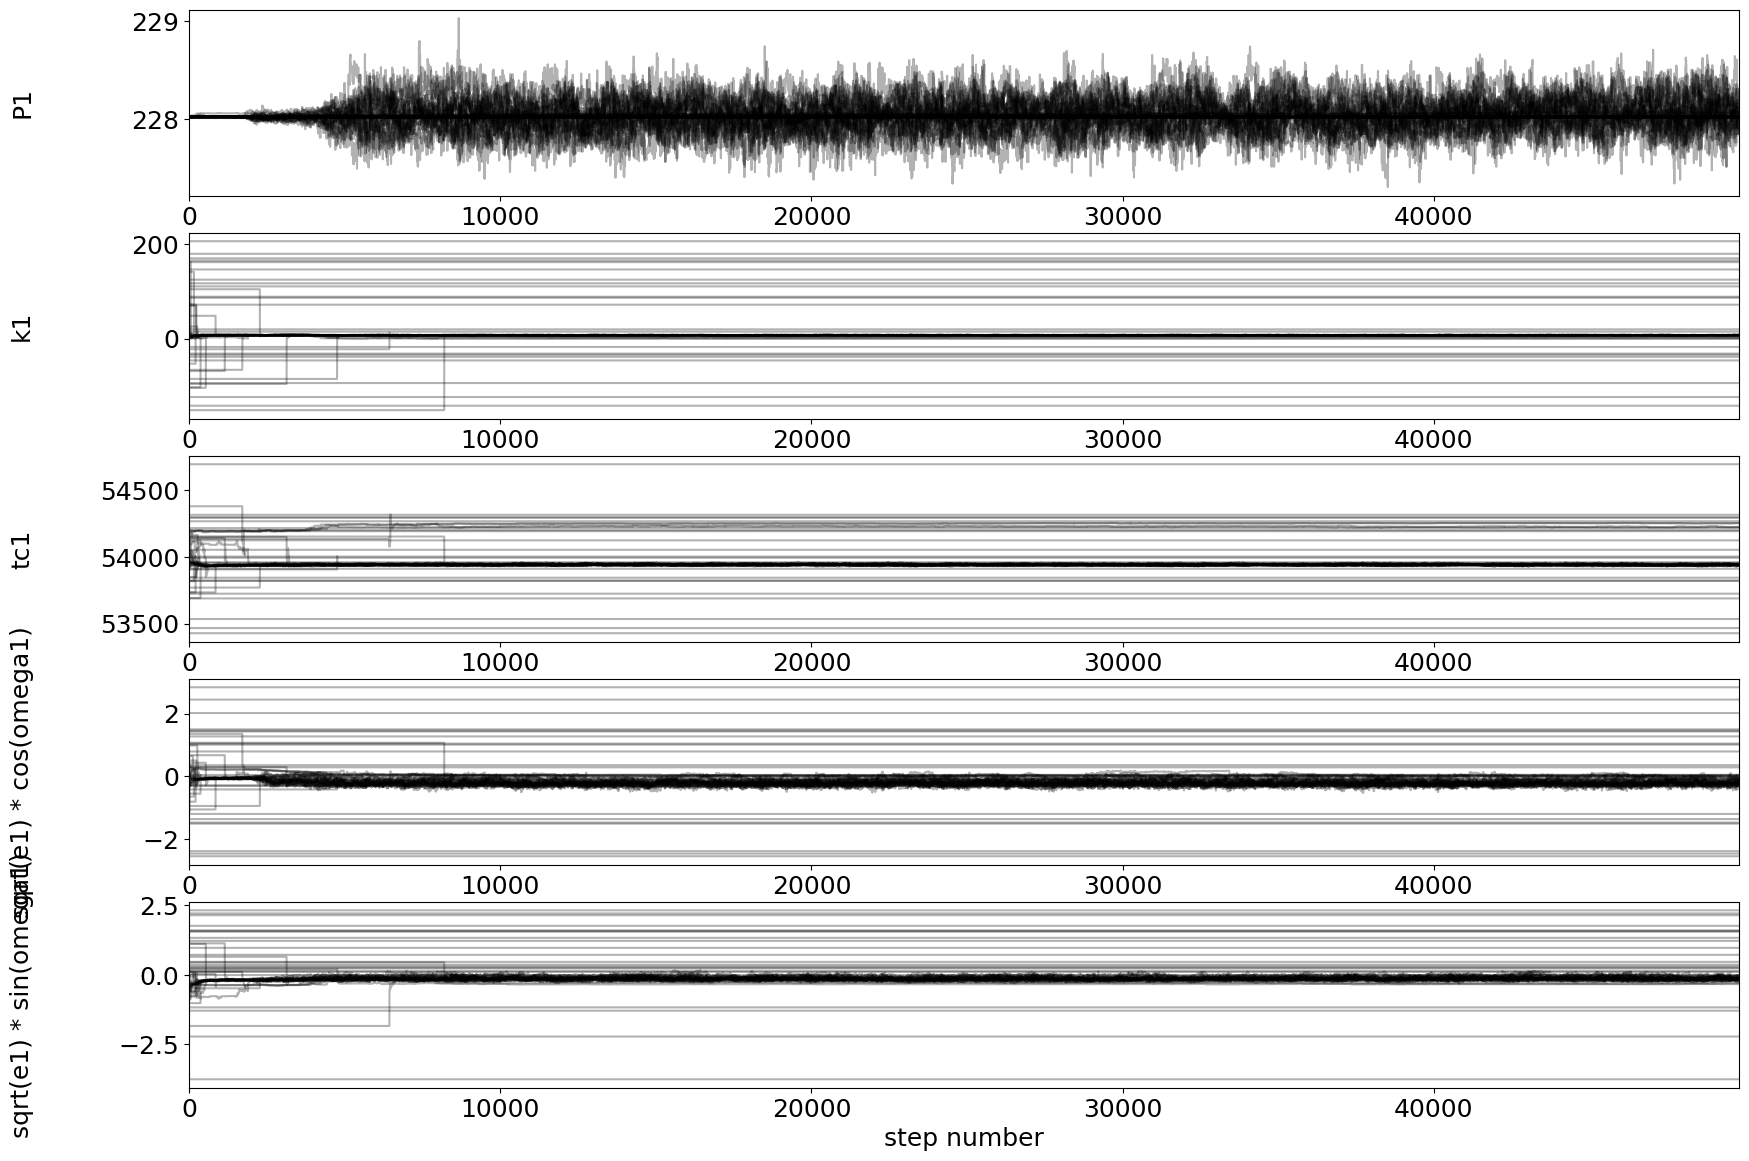

In [11]:
_, axes = pl.subplots(5, figsize=(20, 14))
labels1 = ['P1', 'k1', 'tc1', 'sqrt(e1) * cos(omega1)', 'sqrt(e1) * sin(omega1)']

for i in range(5):
    ax = axes[i]
    ax.plot(samples[:, :, i], 'k', alpha = 0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels1[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
axes[-1].set_xlabel("step number");

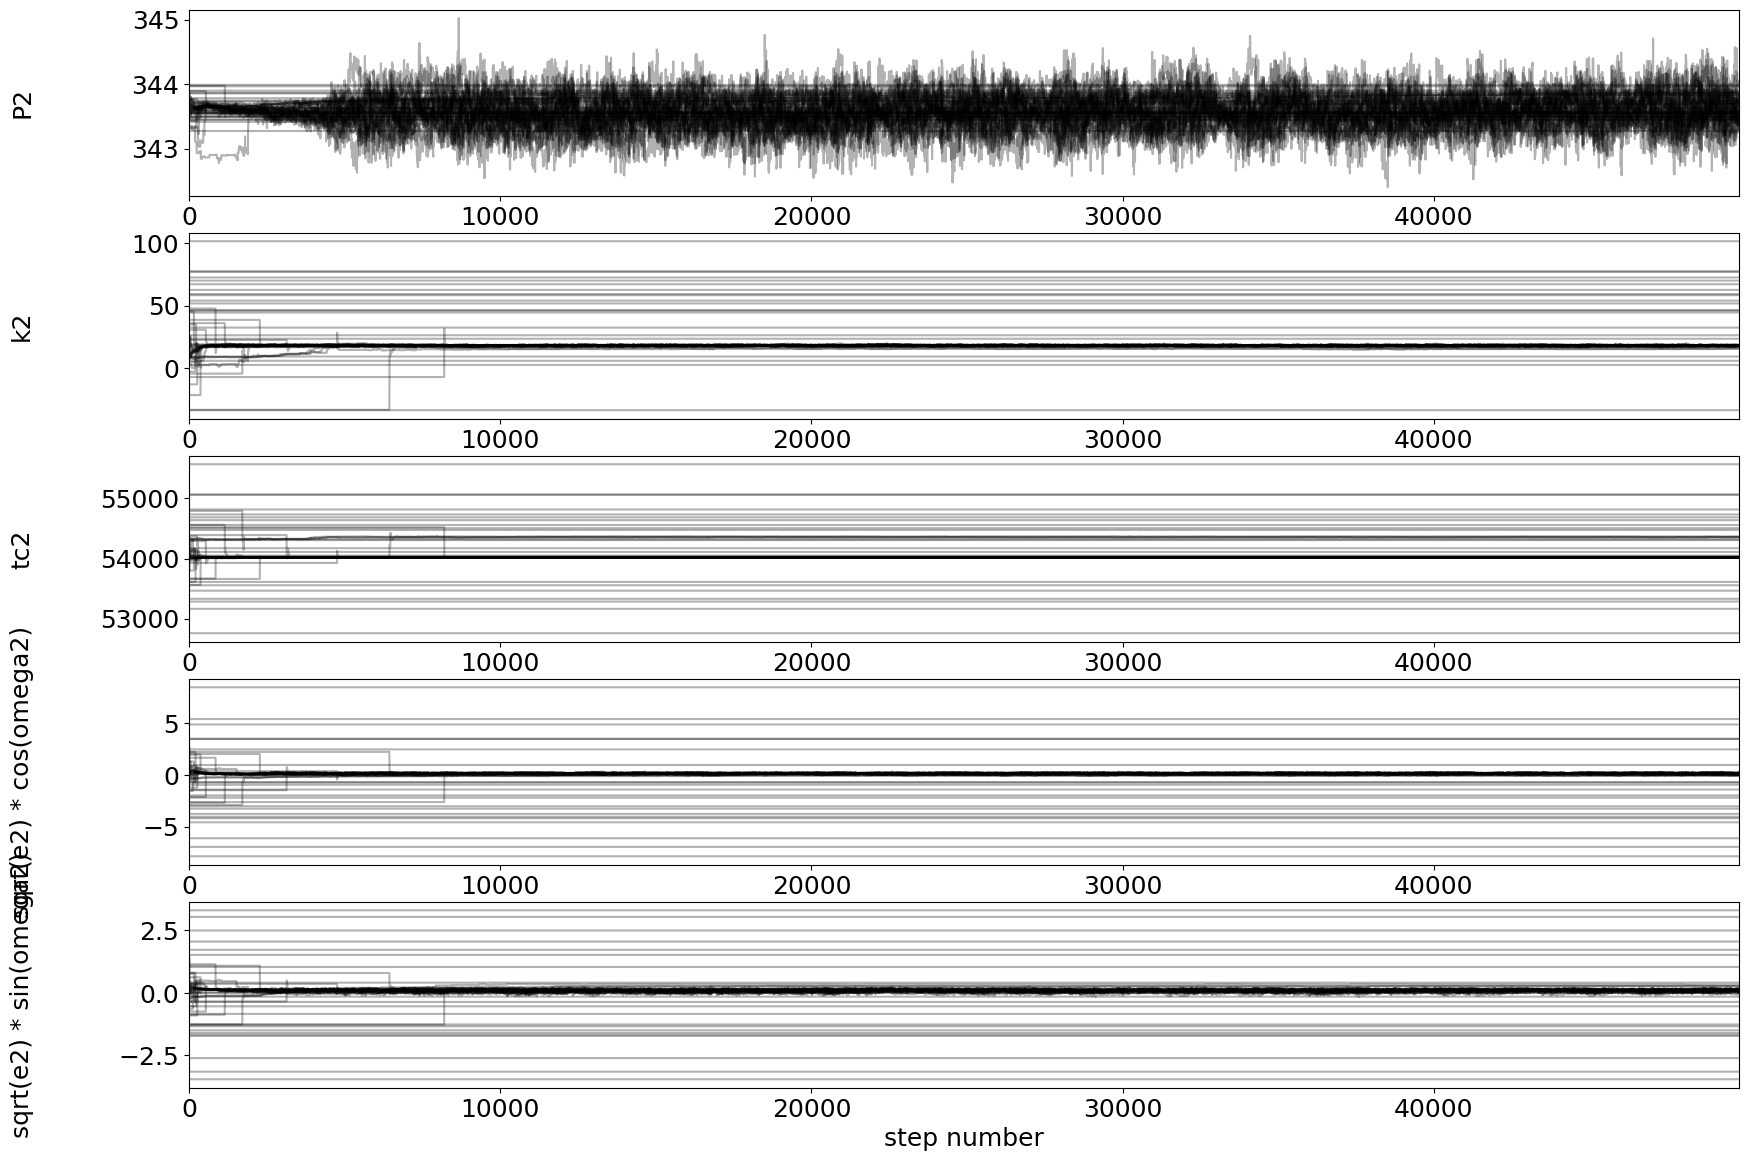

In [12]:
_, axes = pl.subplots(5, figsize=(20, 14))
labels2 = ['P2', 'k2', 'tc2', 'sqrt(e2) * cos(omega2)', 'sqrt(e2) * sin(omega2)']

for i in range(5, 10):
    ax = axes[i - 5]
    ax.plot(samples[:, :, i], 'k', alpha = 0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels2[i - 5])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
axes[-1].set_xlabel("step number");

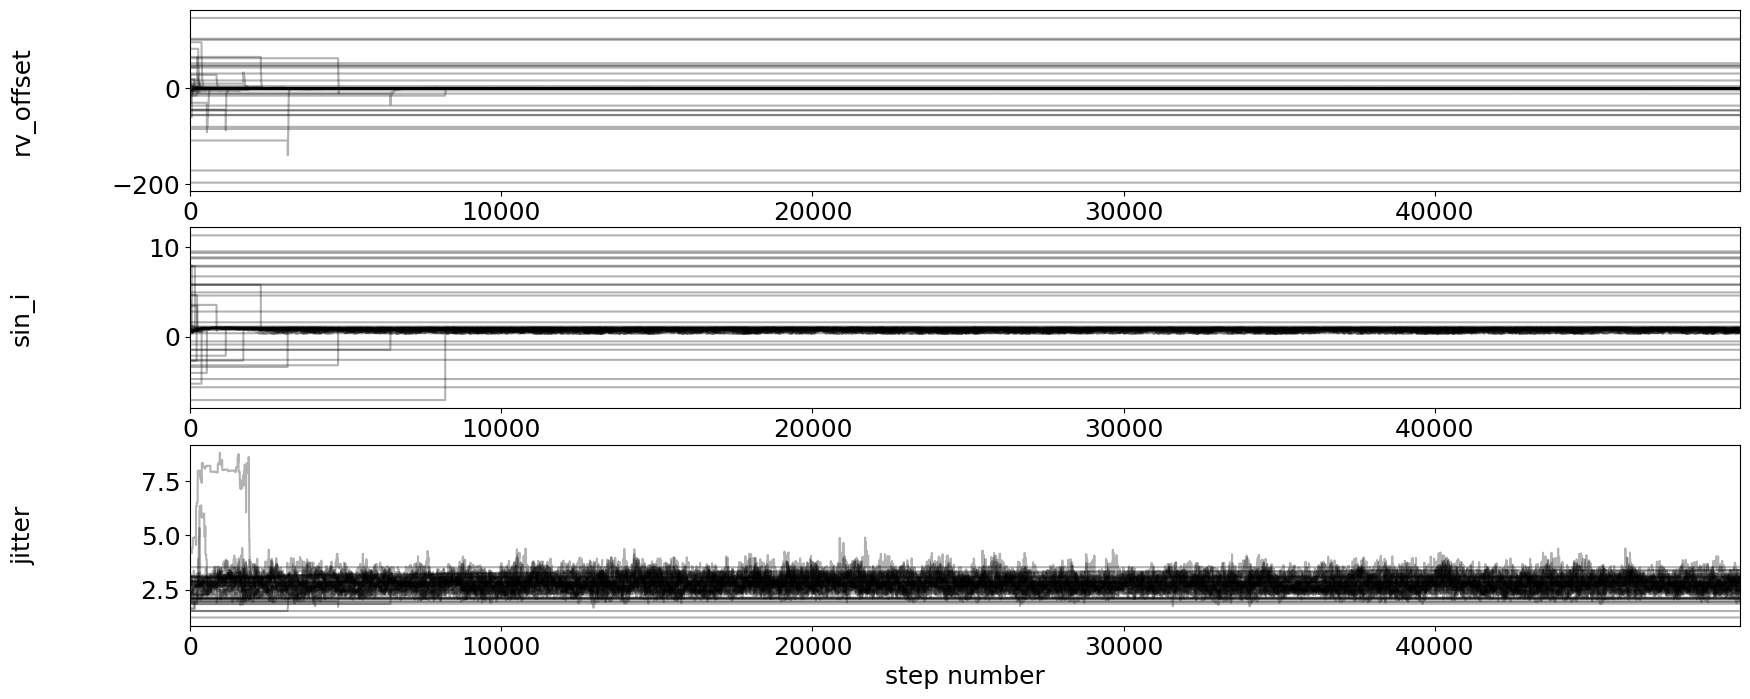

In [13]:
_, axes = pl.subplots(3, figsize=(20, 8))
labels3 = ['rv_offset', 'sin_i', 'jitter']
for i in range(10, 13):
    ax=axes[i - 10]
    ax.plot(samples[:, :, i], 'k', alpha = 0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels3[i - 10])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
axes[-1].set_xlabel("step number");
        
# pl.figure(figsize = (20, 4))
# pl.plot(samples[:, :, 10], 'k', alpha = 0.3)
# pl.xlim(0, len(samples))
# pl.xlabel('step number'), pl.ylabel('rv_offset')

Flatten and make corner plots:

In [14]:
samples = samples[200:]  # discard the first 200 samples ("burn-in" time)
log_prob = log_prob[200:]  # discord the same log probs
flat_samples = samples.reshape(-1, samples.shape[-1])  # reshape the chain to flatten it out
# flat_samples.shape

In [15]:
msini = semiamp_to_mass(17.872/AUDAY_MS, star_mass=STAR_MASS, period=343.361, eccentricity=0.027, inclination=np.pi/2)
msini/0.962

0.5869288051335644

In [16]:
# # plot this only if needed since it takes a long time

# start = time.time() # time the plotting since the rendering and display takes a long time
# labels = np.concatenate((labels1, labels2, labels3))
# cornerplot = corner.corner(
#     flat_samples, labels = labels, show_titles=True, quantiles=[0.05, 0.5, 0.95], verbose=False)
# end = time.time()
# print(f'time to plot: {end - start}')  # takes about 5 minutes or so to plot which is a bit annoying

Finding best fit of MCMC by log probability:

In [17]:
best_fit_loc = np.argmax(log_prob)
best_params_mcmc = flat_samples[best_fit_loc]

In [18]:
best_params_mcmc

array([ 2.28018967e+02,  7.27987225e+00,  5.39380063e+04, -6.66222454e-02,
       -1.91812931e-01,  3.43604228e+02,  1.78149599e+01,  5.40187581e+04,
        9.37456925e-02,  1.00822880e-01, -4.80071660e-01,  9.10201924e-01,
        2.41877817e+00])

In [25]:
log_probability(best), log_probability(best_params_mcmc)

(-145.84417438583546, -146.21289401963895)

Unpenalized best-fit (`best`) taken from the other notebook for comparison:

In [49]:
best_unpenalized = [2.27442446e+02, 7.22321633e+00, 5.39394538e+04, -4.03187699e-02, 
                    -1.87675995e-01, 3.43961865e+02, 1.78997708e+01, 5.40179199e+04, 
                    8.62286367e-02, 1.28714526e-01, -5.35295278e-01, 1.00000000e+00, 2.44160836e+00]

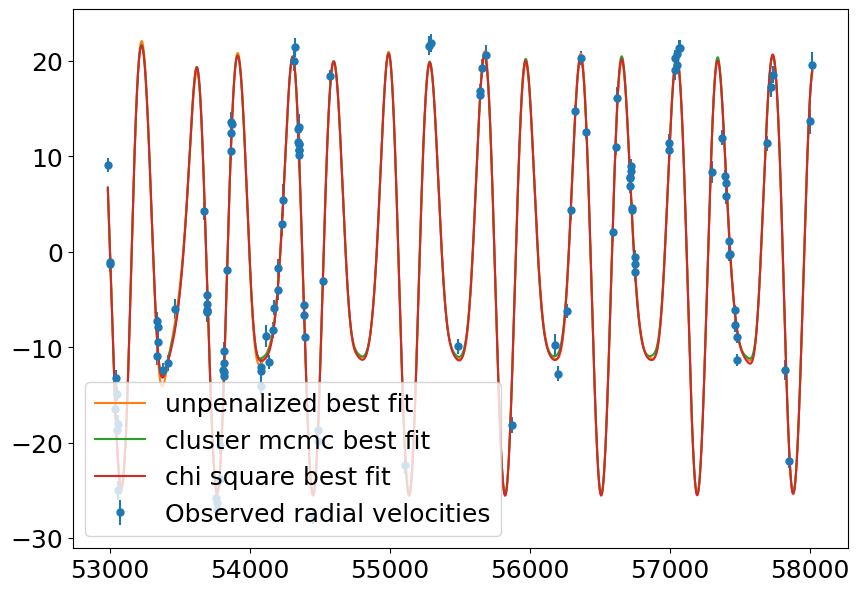

In [50]:
times = np.linspace(np.min(hd_data.BJD), np.max(hd_data.BJD), int(1e4))

pl.figure(figsize = (10, 7))
pl.errorbar(hd_data.BJD, hd_data.RV_mlc_nzp, yerr = hd_data.e_RV_mlc_nzp, fmt= 'o', label = 'Observed radial velocities')
pl.plot(times, get_rvs(best_unpenalized, times = times, integrator = 'ias15', time_base = obs_time_base), label = 'unpenalized best fit')
pl.plot(times, get_rvs(best_params_mcmc, times = times, integrator = 'ias15', time_base = obs_time_base), label = 'cluster mcmc best fit')  # best fit params mcmc
pl.plot(times, get_rvs(best, times = times, integrator = 'ias15', time_base = obs_time_base), label = 'chi square best fit')  # best fit params with chi square
# pl.plot(times, get_rvs(fit_params.x, inclination= np.pi/2, times = times, integrator = 'ias15'), label = 'no chi square')  # earlier fit only with least squares
pl.legend(loc = 'lower left')

In [37]:
e1 = samples[:, :, 3] ** 2 + samples[:, :, 4] ** 2  # computing eccentricity
e2 = samples[:, :, 8] ** 2 + samples[:, :, 9] ** 2  # computing eccentricity
p1 = samples[:, :, 0]
k1 = samples[:, :, 1]
p2 = samples[:, :, 5]
k2 = samples[:, :, 6]
tc1 = samples[:, :, 2]
tc2 = samples[:, :, 7]
omega1 = np.arctan2(samples[:, :, 3], samples[:, :, 4])  # omega is argument of periapsis
omega2 = np.arctan2(samples[:, :, 8], samples[:, :, 9])

jitter = samples[:, :, -1]
sin_i = samples[:, :, -2] # sin_i
rv_offset = samples[:, :, -3]  # rv_offset

 # print(k1.shape, p1.shape, e1.shape)

m1 = semiamp_to_mass(k1/(AUDAY_MS), STAR_MASS, p1, e1, inclination = np.arcsin(sin_i))
m2 = semiamp_to_mass(k2/(AUDAY_MS), STAR_MASS, p2, e2, inclination = np.arcsin(sin_i))
# print(m1.shape, e1.shape, m2.shape, e1.shape)

In [38]:
p1_best, k1_best, tc1_best, sq_e1cosomega1_best, sq_e1sinomega1_best, p2_best, k2_best, tc2_best, sq_e2cosomega2_best, sq_e2sinomega2_best, rv_offset_best, sini_best, jitter_best = best
e1_best = sq_e1cosomega1_best ** 2 + sq_e1sinomega1_best ** 2
e2_best = sq_e2cosomega2_best ** 2 + sq_e2sinomega2_best ** 2
omega1_best = np.arctan2(sq_e1cosomega1_best, sq_e1sinomega1_best)
omega2_best = np.arctan2(sq_e2cosomega2_best, sq_e2sinomega2_best)

m1_best = semiamp_to_mass(k1_best/AUDAY_MS, STAR_MASS, p1_best, e1_best, inclination = np.arcsin(sini_best))
m2_best = semiamp_to_mass(k2_best/AUDAY_MS, STAR_MASS, p2_best, e2_best, inclination = np.arcsin(sini_best))

pd.DataFrame(data = [m1_best, p1_best, e1_best, tc1_best, omega1_best, 
                     m2_best, p2_best, e2_best, tc2_best, omega2_best, rv_offset_best, sini_best, jitter_best], 
             index = ['m1', 'p1', 'e1', 'tc1', 'omega1', 
                              'm2', 'p2', 'e2', 'tc2', 'omega2', 
                              'rv_offset', 'sin_i', 'jitter'], columns=['best'])

,best
m1,0.197581
p1,228.019539
e1,0.038801
tc1,53937.706439
omega1,-2.847247
m2,0.567358
p2,343.600780
e2,0.015899
tc2,54019.002614
omega2,0.667101


In [39]:
pd.DataFrame(data=[np.quantile(m1.reshape(-1), [0.05, 0.5, 0.95]), 
                   np.quantile(p1.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(e1.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(tc1.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(omega1.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(m2.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(p2.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(e2.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(tc2.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(omega2.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(rv_offset.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(sin_i.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(jitter.reshape(-1), [0.01, 0.5, 0.95])
                  ], index = ['m1', 'p1', 'e1', 'tc1', 'omega1', 
                              'm2', 'p2', 'e2', 'tc2', 'omega2', 
                              'rv_offset', 'sin_i', 'jitter'], 
             columns=['5%', '50%', '95%'])

,5%,50%,95%
m1,NaN,NaN,NaN
p1,227.855807,228.020111,228.214228
e1,0.037679,0.110793,10.857722
tc1,53534.113083,53943.853276,54298.127022
omega1,-2.768030,-1.615811,3.028671
m2,NaN,NaN,NaN
p2,343.273657,343.585458,343.966653
e2,0.013446,0.075709,58.092111
tc2,53283.753161,54019.515832,55059.980112
omega2,-1.996212,0.557128,1.418051


(array([  57771.,   49941.,   59569.,  155039., 1510089.,   50287.,
          99228.,  150876.,  248000.,   99200.]),
 array([-7.0563464 , -5.22319583, -3.39004525, -1.55689468,  0.2762559 ,
         2.10940648,  3.94255705,  5.77570763,  7.6088582 ,  9.44200878,
        11.27515936]),
 <BarContainer object of 10 artists>)

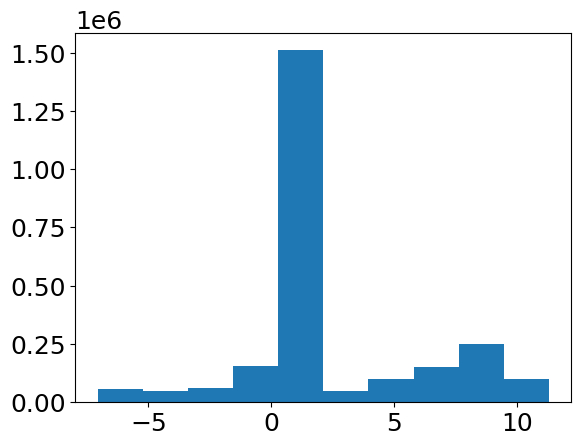

In [40]:
pl.hist(sin_i.reshape(-1))

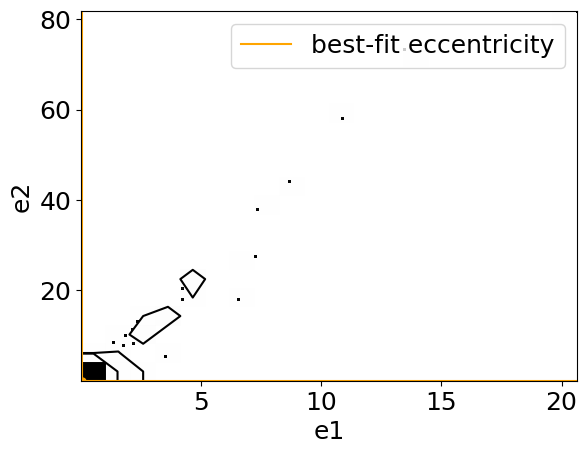

In [41]:
corner.hist2d(e1.reshape(-1), e2.reshape(-1))  # 2d histogram of eccentricities
# pl.scatter(e_inner, e_outer, label = 'ecc track w damping')  # TODO: find best-fit track of eccentricities
# plot true e value on top
true_es = [best[3] ** 2 + best[4] ** 2, best[8] ** 2 + best[9] ** 2]
pl.scatter(true_es[0], true_es[1], color = 'orange')
pl.axvline(true_es[0], color = 'orange'), pl.axhline(true_es[1], color = 'orange', label = 'best-fit eccentricity')
pl.xlabel('e1'), pl.ylabel('e2')
pl.legend(loc = 'upper right')

In [42]:
corner.quantile(m1.reshape(-1), [0.05, 0.95]), corner.quantile(m2.reshape(-1), [0.05, 0.95]), #true_ms

(array([nan, nan]), array([nan, nan]))

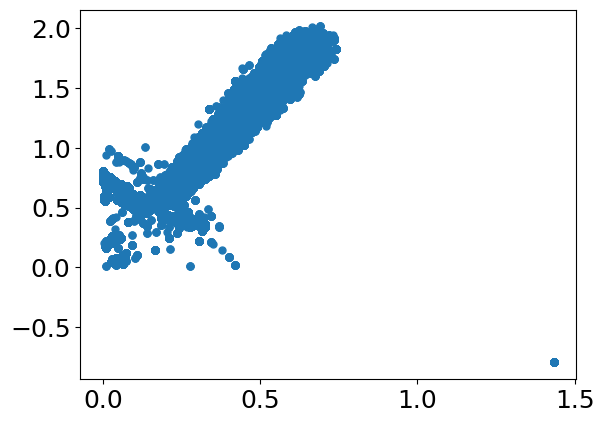

In [43]:
pl.scatter(m1.reshape(-1), m2.reshape(-1))

In [44]:
corner.quantile(e1.reshape(-1), [0.05, 0.95]), corner.quantile(e2.reshape(-1), [0.05, 0.95])

(array([ 0.03767874, 10.85772225]), array([1.34462354e-02, 5.80921112e+01]))

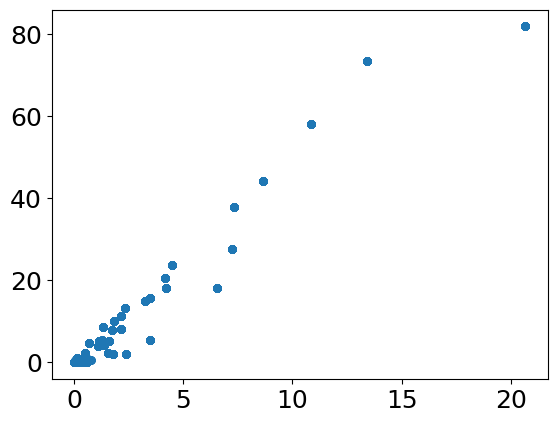

In [45]:
pl.scatter(e1.reshape(-1), e2.reshape(-1))

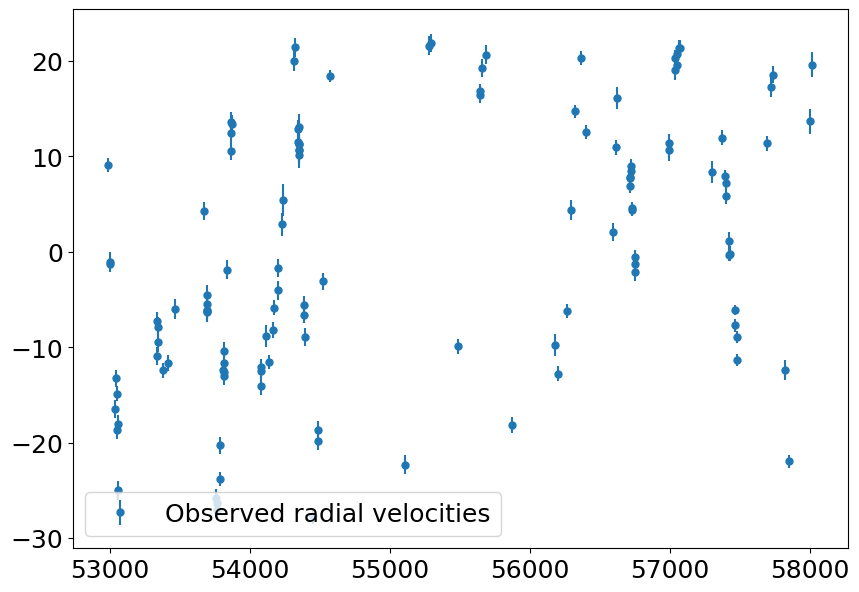

In [52]:
pl.figure(figsize = (10, 7))
pl.errorbar(hd_data.BJD, hd_data.RV_mlc_nzp, yerr = hd_data.e_RV_mlc_nzp, fmt= 'o', label = 'Observed radial velocities')
pl.plot(times, get_rvs(flat_samples[22], times = times, integrator = 'ias15', time_base = obs_time_base))
pl.legend(loc = 'lower left')

In [60]:
testsim = get_sim_from_params(flat_samples[22], 'ias15', obs_time_base)
testsim.status()

nan 228.01882932344583 7.324543038683899 53844.54754554378 -2.641757955776379 nan
nan 343.2736570506444 37.9183612078077 53329.30800224704 0.5137228048197894 nan
---------------------------------
REBOUND version:     	3.27.0
REBOUND built on:    	Sep 17 2023 11:57:46
Number of particles: 	3
Selected integrator: 	ias15
Simulation time:     	5.4422789665000048e+04
Current timestep:    	0.001000
---------------------------------
<rebound.particle.Particle object at 0x7f202a6ca340, m=920.0 x=nan y=nan z=nan vx=nan vy=nan vz=nan>
<rebound.particle.Particle object at 0x7f20251d5640, m=nan x=nan y=nan z=nan vx=nan vy=nan vz=nan>
<rebound.particle.Particle object at 0x7f202a6ca340, m=nan x=nan y=nan z=nan vx=nan vy=nan vz=nan>
---------------------------------
The following fields have non-default values:
t:
< 0.000000e+00
---
> 5.442279e+04
G:
< 1.000000e+00
---
> 2.824761e-07
N:
< 0
---
> 3
python_unit_l:
< 0
---
> 2690299139
python_unit_m:
< 0
---
> 2145773914
python_unit_t:
< 0
---
> 66112

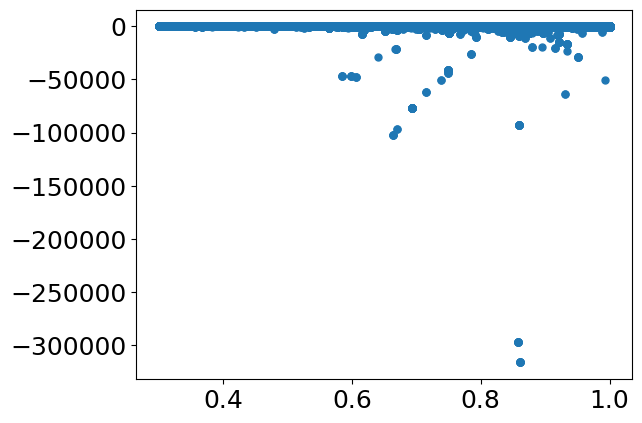

In [63]:
pl.scatter(samples.reshape(-1, 13)[:,-2], log_prob.reshape(-1))  # sin(i) doesn't seem to affect it so much anymore when I add in jitter... why????

In [64]:
total_mass = m1.reshape(-1) + m2.reshape(-1)
sin_is = sin_i.reshape(-1)

(array([  57771.,   49941.,   59569.,  155039., 1510089.,   50287.,
          99228.,  150876.,  248000.,   99200.]),
 array([-7.0563464 , -5.22319583, -3.39004525, -1.55689468,  0.2762559 ,
         2.10940648,  3.94255705,  5.77570763,  7.6088582 ,  9.44200878,
        11.27515936]),
 <BarContainer object of 10 artists>)

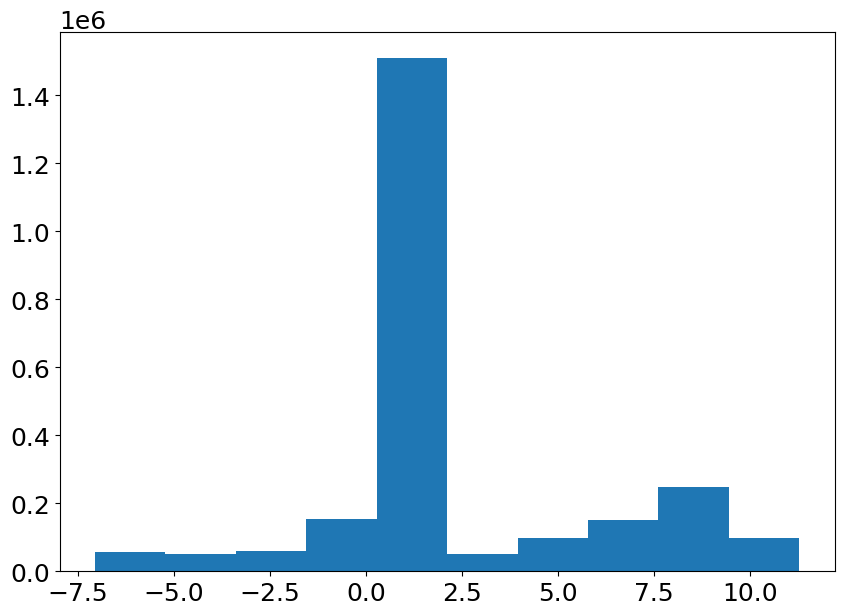

In [65]:
pl.figure(figsize = (10, 7))
pl.hist(sin_is)
# pl.hist(total_mass)

In [66]:
np.quantile(sin_is, [0.05, 0.5, 0.95]), np.quantile(e1.reshape(-1), [0.05, 0.5, 0.95]), np.quantile(e2.reshape(-1), [0.05, 0.5, 0.95])

(array([-2.57704134,  0.88326465,  9.31228347]),
 array([ 0.03767874,  0.1107928 , 10.85772225]),
 array([1.34462354e-02, 7.57086621e-02, 5.80921112e+01]))

In [69]:
best

array([ 2.28019539e+02,  7.17109444e+00,  5.39377064e+04, -5.71465755e-02,
       -1.88508433e-01,  3.43600780e+02,  1.79500370e+01,  5.40190026e+04,
        7.80144162e-02,  9.90600474e-02, -5.54386405e-01,  1.00000000e+00,
        2.42727225e+00])

In [68]:
m1_best, m2_best, m1_best/sini_best, m2_best/sini_best

(0.19758061761937135, 0.5673580305516158, 0.19758061761937135, 0.5673580305516158)

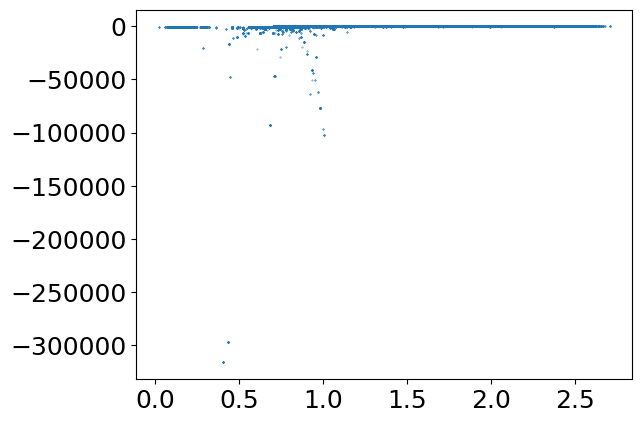

In [71]:
pl.scatter(total_mass, log_prob.reshape(-1), s=0.1)  # sin(i) doesn't seem to affect it so much anymore when I add in jitter... why????

ValueError: It looks like the provided 'range' is not valid or the sample is empty.

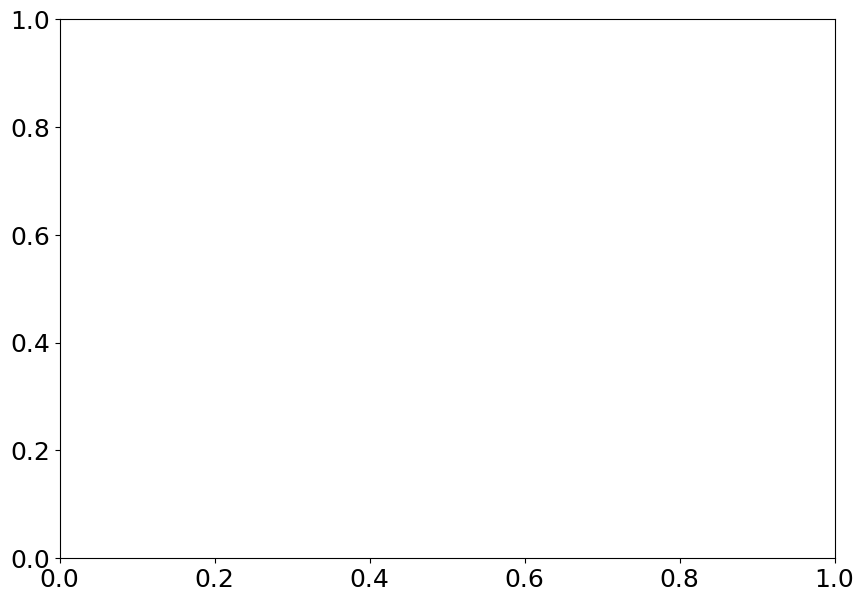

In [72]:
import matplotlib as mpl

pl.figure(figsize = (10, 7))
# contour lines
corner.hist2d(total_mass, sin_is, s=0.1, bins=200, plot_datapoints=False, plot_density=False, levels=[0.68, 0.95, 0.99], color='r', label = 'Contours')
# histogram with log norm
pl.hist2d(total_mass, sin_is, norm=mpl.colors.LogNorm(), bins=1000)  # log norm
pl.scatter(m1_best + m2_best, sini_best, color = 'black', label ='Best fit', s=100)  # best-fit point
pl.scatter(m1sini_tail + m2sini_tail, sini_tail, color = 'orange', label = 'Tail point', s=100)  # fit for a tail point
pl.xlabel(r'Total mass of planets ($M_J$)'), pl.ylabel(r'$\sin(i)$')
pl.annotate(fr'$ \log L \approx {np.round(neg_log_likelihood(best), 2)}$', 
            xy=(m1_best/sini_best + m2_best/sini_best, sini_best), 
            xycoords='data', 
            textcoords='axes fraction', xytext=(0.05, 0.95), color='black')#, arrowprops=dict(facecolor='red', shrink=0.01), color ='red')
pl.annotate(fr'$ \log L \approx {np.round(neg_log_likelihood(flat_samples[tail_index]), 2)}$', 
            xy=(m1sini_tail/sini_tail + m2sini_tail/sini_tail, sini_tail), 
            xycoords='data', 
            textcoords='axes fraction', xytext=(0.75, 0.1), color='orange')#, arrowprops=dict(facecolor='red', shrink=0.01), color ='red')
# pl.annotate(fr'$K \approx {int(np.round(K_dist_bounds[0], roundto))}$', xy=(np.max(e1_dist), np.max(e2_dist)), xycoords='data', 
#             textcoords='axes fraction', xytext=(0.8, 0.8), arrowprops=dict(facecolor='red', shrink=0.01), color ='red')
# x limit
# pl.xlim(right=1.1), pl.ylim(bottom=0.7)
pl.legend()
# pl.savefig('sin_i_mtot_dist.png')#, fmt='png')

TODO: looks like the chains may be initializing in the wrong place, check the jacobian to make sure the walkers are initializing in reasonable places... then maybe the mcmc can do its job from there